In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:

!pip install trl==0.11.3
!pip install -U bitsandbytes accelerate
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4oawq0tx
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-4oawq0tx
  Resolved https://github.com/huggingface/transformers to commit 1cea763ba422b83778a8db0374ea90f43b09992b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from huggingface_hub import login
from google.colab import userdata
import os, re, tempfile, subprocess, textwrap, random, json, datetime
import torch, itertools
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, GenerationConfig,
    BitsAndBytesConfig, set_seed, DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model
#from trl import GRPOTrainer, GRPOConfig
from trl import PPOTrainer, PPOConfig
from trl import AutoModelForCausalLMWithValueHead
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!export TORCH_USE_CUDA_DSA=1
#login(token=userdata.get("HF_TOKEN"))

PLAYER_MODEL_ID = "Qwen/Qwen3-4B"
#PLAYER_MODEL_ID = "Qwen/Qwen2.5-Coder-0.5B-Instruct"
DEVICE          = "cpu"
GLOBAL_SEED     = 42
MAX_NEW_TOKENS  = 512
GEN_BATCH       = 8
BATCH_SIZE      = 2
set_seed(GLOBAL_SEED)
torch.backends.cuda.matmul.allow_tf32 = True

HASH_FENCE_RE  = re.compile(r"(?m)^\s*#{3}\s*$")
BTICK_FENCE_RE = re.compile(r"(?:python)?\n([\s\S]*?)", re.I)
PRED_RE        = re.compile(r"<\s*(-?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?)\s*>")

def extract_code_and_pred(txt: str):
    """
    From a full LLM completion, return (code_block:str, numeric_prediction:float).
    Raises ValueError if either chunk is missing.
    """
    txt = txt.replace("python", "")
    code, search_from = None, None

    fences = list(HASH_FENCE_RE.finditer(txt))
    if len(fences) >= 2:                         # ### … ###
        code  = txt[fences[0].end():fences[1].start()].strip()
        search_from = fences[1].end()
    else:                                        # ```python … ```
        m = BTICK_FENCE_RE.search(txt)
        if not m:
            raise ValueError("could not find fenced code")
        code        = m.group(1).strip()
        search_from = m.end()

    m_pred = PRED_RE.search(txt, pos=search_from)
    if not m_pred:
        raise ValueError("no numeric prediction found after code block")
    return code, float(m_pred.group(1))

def run_python(code: str, timeout_s: int = 4) -> float:
    """Executes *code* and returns the last numeric line printed."""
    with tempfile.NamedTemporaryFile("w", suffix=".py", delete=False) as fh:
        fh.write(code)
        path = fh.name
    try:
        proc = subprocess.run(["python", path],
                              text=True, capture_output=True, timeout=timeout_s)
    finally:
        os.remove(path)
    if proc.returncode != 0:
        raise RuntimeError(proc.stderr.strip())
    for line in reversed(proc.stdout.strip().splitlines()):
        try:
            return float(line.strip())
        except ValueError:
            continue
    raise RuntimeError("no numeric output")

tokenizer = AutoTokenizer.from_pretrained(PLAYER_MODEL_ID, padding_side="left", enable_thinking=False)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_cfg = BitsAndBytesConfig(load_in_8bit=True)
lora_cfg = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, bias="none",
    task_type="CAUSAL_LM",
)


player_cfg = PPOConfig(
    learning_rate=1e-5,
    batch_size=4,
    mini_batch_size=1,
    gradient_accumulation_steps=2,
    seed=GLOBAL_SEED,
    steps=1
    #logging_steps=10,
    #save_steps=50,
    #max_steps=10,
)

opp_cfg = PPOConfig(
    #output_dir="opp‑ppo",
    learning_rate=1e-5,
    batch_size=4,
    mini_batch_size=1,
    gradient_accumulation_steps=2,
    seed=GLOBAL_SEED,
    steps=1,
    #logging_steps=10,
    #save_steps=50,
    #max_steps=10,
)

def load_lora_model(cfg) -> torch.nn.Module:
    base = AutoModelForCausalLMWithValueHead.from_pretrained(
        PLAYER_MODEL_ID, load_in_8bit=True, peft_config=lora_cfg,)
# )
    #model = get_peft_model(base, lora_cfg)
    #model.generation_config = GenerationConfig.from_model_config(model.config)
    return base

player_model  = load_lora_model(player_cfg)
player_ref = load_lora_model(player_cfg)

opp_model     = load_lora_model(opp_cfg)
opp_ref = load_lora_model(opp_cfg)

@torch.no_grad()
def predict_output(model, code: str) -> float | None:
    prompt = (
        "I will show you a Python script.\n"
        "Predict the numeric value it prints *exactly*.\n\n"
        f"python\n{code}\n"
    )
    toks = tokenizer(prompt, return_tensors="pt").to(next(model.parameters()).device)
    out  = model.generate(**toks, max_new_tokens=32, temperature=0.0,
                          do_sample=False, eos_token_id=tokenizer.eos_token_id)
    txt  = tokenizer.decode(out[0], skip_special_tokens=True)
    m    = re.search(r"-?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?", txt)
    return float(m.group()) if m else None
def player_reward(prompts, completions, **_):
    """+1 if Player right & Opponent wrong, -1 vice versa, 0 otherwise."""
    rews = []
    for comp in completions:
        try:
            code, p_pred = extract_code_and_pred(comp)
            true_out     = run_python(code)
            COLLECTED_CODES.append(code)

        except Exception:
            rews.append(-1.0);
            COLLECTED_CODES.append('NA')
            continue
        o_pred   = predict_output(opp_model, code)
        p_ok     = abs(p_pred-true_out)  < 1e-6
        o_ok     = o_pred is not None and abs(o_pred-true_out) < 1e-6
        rews.append(+1.0 if  p_ok and not o_ok else
                    -1.0 if not p_ok and  o_ok else 0.0)

        print("reward", rews)
        with open("all_rewards.csv","a") as f:
          for r in rews:
              f.write(f"{r}\n")

    return rews

def opp_reward(prompts, completions, **_):
    """Mirror image for the Opponent."""
    rews = []
    print(completions)
    for comp in completions:
        try:
            code, o_pred = extract_code_and_pred(comp)
            true_out     = run_python(code)
            print(code)
            print(o_pred)
        except Exception:
            rews.append(-1.0); continue
        p_pred  = predict_output(player_model, code)
        o_ok    = abs(o_pred-true_out)  < 1e-6
        p_ok    = p_pred is not None and abs(p_pred-true_out) < 1e-6
        rews.append(+1.0 if  o_ok and not p_ok else
                    -1.0 if not o_ok and  p_ok else 0.0)

        print("reward", rews)
        with open("all_rewards.csv","a") as f:
          for r in rews:
              f.write(f"{r}\n")
    return rews

BASE_PROMPT = textwrap.dedent("""\
  We're going to play a game to test your capabilities.
  1. Write a stand‑alone python script between ### … ### that prints one numeric value.
  2. Predict that numeric value enclosed in <>.
  3. You score +1 if you are right and the Opponent is wrong; 0 otherwise.
  FORMAT:
  ###
  code
  ###
  <prediction>
""")
RAW_DS = Dataset.from_dict({"prompt": [BASE_PROMPT]*4_000})

def tokenize(ds):
    return tokenizer(ds["prompt"], truncation=True, max_length=512)


def create_batched_dataset(dataset, tokenizer, collator, batch_size=8):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collator,  # or your custom collator
    )

    batched_data = []
    for batch in dataloader:
        # Convert all tensors to device-agnostic (will move to cuda later)
        batched_data.append({k: v for k, v in batch.items()})

    return batched_data  # list of dicts, one dict per batch

train_ds      = RAW_DS.map(tokenize, batched=True, remove_columns=["prompt"])
train_ds.set_format("torch", columns=["input_ids", "attention_mask"])
collator      = DataCollatorWithPadding(tokenizer, return_tensors="pt")

batched_train_ds = create_batched_dataset(train_ds, tokenizer=tokenizer, batch_size=BATCH_SIZE, collator=collator)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:

def ppo_train_one_step(
    batch,
    ppo_trainer,
    reward_fn,
    generation_kwargs,
    save_path=None,
    device="cuda",
    store_codes=True,
):
    #batch = ppo_trainer.dataset[batch_id]
    #print(ppo_trainer.dataset)
    #print(batch)
    query_tensors = batch["input_ids"].to(device)

    query_list = list(query_tensors.unbind(dim=0))            # List of B tensors, each [L]

    for i, q in enumerate(query_list):
      # 1D tensor?
      assert q.ndim == 1, f"query_list[{i}] has shape {q.shape}"
      # no negative IDs
      assert int(q.min()) >= 0,     f"Negative token in example {i}"
      # below vocab
      assert int(q.max()) < ppo_trainer.model.config.vocab_size, (
          f"Token id {int(q.max())} >= vocab size "
          f"{ppo_trainer.model.config.vocab_size} at example {i}"
      )

    # Generate responses
    response_tensors = ppo_trainer.generate(
        query_list,
        return_prompt=False,
        generate_ref_response=False,
        **generation_kwargs,
    )

    response_tensors = [r.to(device) for r in response_tensors]


    batch['response'] = tokenizer.batch_decode(response_tensors)
    response_texts = batch['response']
    prompt_texts = tokenizer.batch_decode(query_tensors)

    #prompt_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

    rewards = reward_fn(prompt_texts, response_texts)
    print(rewards)
    if not isinstance(rewards, torch.Tensor):
        rewards = torch.tensor(rewards, dtype=torch.float)

    rewards = rewards.to(device)
    reward_list = [r.unsqueeze(0) for r in rewards.unbind(dim=0)]

    stats = ppo_trainer.step(query_list, response_tensors, reward_list)
    ppo_trainer.log_stats(stats, batch, reward_list)

    if save_path:
        ppo_trainer.save_pretrained(save_path)

    return stats


In [ ]:
'''
def ppo_train_one_step(
    batch,
    ppo_trainer,
    reward_fn,
    generation_kwargs,
    tokenizer,
    save_path=None,
    device=None,
    store_codes=True,
):
    import torch

    if device is None:
        device = ppo_trainer.model.device

    # Move input_ids to device
    query_tensors = batch["input_ids"].to(device)
    query_list = list(query_tensors.unbind(dim=0))  # List of B tensors, each [L]

    # Validate queries
    for i, q in enumerate(query_list):
        if q.ndim != 1:
            raise ValueError(f"[ERROR] query[{i}] has shape {q.shape}, not 1D")
        if int(q.min()) < 0:
            raise ValueError(f"[ERROR] query[{i}] contains negative token IDs")
        if int(q.max()) >= ppo_trainer.model.config.vocab_size:
            raise ValueError(f"[ERROR] query[{i}] contains token ID >= vocab size ({ppo_trainer.model.config.vocab_size})")
        if q.dtype != torch.long:
            raise ValueError(f"[ERROR] query[{i}] has dtype {q.dtype}, expected torch.long")

    for i, q in enumerate(query_list):
        max_id = q.max().item()
        if max_id >= player_model.config.vocab_size:
            print(f"[ERROR] Query {i} has token ID {max_id} >= vocab size {model.config.vocab_size}")


    # DEBUG: Generate one by one to isolate failures
    response_tensors = []
    for i, q in enumerate(query_list):
        try:
            with torch.no_grad():
                response = ppo_trainer.generate(
                    [q],
                    return_prompt=False,
                    generate_ref_response=False,
                    **generation_kwargs,
                )
                response_tensors.append(response[0])
        except Exception as e:
            print(f"[FATAL] Generation failed at example {i}")
            print(e)
            print(f"Query tokens: {q}")
            print(f"Decoded: {tokenizer.decode(q, skip_special_tokens=True)}")
            raise e  # re-raise the exception

    # Pad response tensors to same length (optional)
    response_tensors = [r.to(device) for r in response_tensors]

    batch['response'] = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)
    response_texts = batch['response']
    prompt_texts = tokenizer.batch_decode(query_tensors, skip_special_tokens=True)

    # Compute rewards
    rewards = reward_fn(prompt_texts, response_texts)
    if not isinstance(rewards, torch.Tensor):
        rewards = torch.tensor(rewards, dtype=torch.float)
    rewards = rewards.to(device)

    # Wrap rewards
    reward_list = [r.unsqueeze(0) for r in rewards]

    # PPO step
    stats = ppo_trainer.step(query_list, response_tensors, reward_list)
    ppo_trainer.log_stats(stats, batch, reward_list)

    if save_path:
        ppo_trainer.save_pretrained(save_path)

    return stats
'''

'\ndef ppo_train_one_step(\n    batch,\n    ppo_trainer,\n    reward_fn,\n    generation_kwargs,\n    tokenizer,\n    save_path=None,\n    device=None,\n    store_codes=True,\n):\n    import torch\n\n    if device is None:\n        device = ppo_trainer.model.device\n\n    # Move input_ids to device\n    query_tensors = batch["input_ids"].to(device)\n    query_list = list(query_tensors.unbind(dim=0))  # List of B tensors, each [L]\n\n    # Validate queries\n    for i, q in enumerate(query_list):\n        if q.ndim != 1:\n            raise ValueError(f"[ERROR] query[{i}] has shape {q.shape}, not 1D")\n        if int(q.min()) < 0:\n            raise ValueError(f"[ERROR] query[{i}] contains negative token IDs")\n        if int(q.max()) >= ppo_trainer.model.config.vocab_size:\n            raise ValueError(f"[ERROR] query[{i}] contains token ID >= vocab size ({ppo_trainer.model.config.vocab_size})")\n        if q.dtype != torch.long:\n            raise ValueError(f"[ERROR] query[{i}] has dty

In [ ]:
print("Vocab size:", player_model.config.vocab_size)


Vocab size: 151936


In [ ]:

player_cfg.output_dir = "./player_ckpt"
opp_cfg.output_dir = "./opp_ckpt"

player_trainer = PPOTrainer(
    config=player_cfg,
    model=player_model,
    ref_model = player_ref,
    tokenizer=tokenizer,
    dataset=train_ds,
    data_collator=collator,
    #reward_model=dummy_reward_model,
    #value_model = player_val,
    )

generation_kwargs_player = {
    "max_new_tokens": MAX_NEW_TOKENS,
    "temperature": 0.8,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "use_cache": False,
}
generation_kwargs_opp = {
    "max_new_tokens": 32,
    "temperature": 0.0,
    "do_sample": False,
    "pad_token_id": tokenizer.pad_token_id,
    "use_cache": False,
}

batch_iter = iter(player_trainer.dataloader)

NUM_ROUNDS = 15
for round_idx in range(NUM_ROUNDS):


    COLLECTED_CODES = []
    print(f"Round {round_idx+1}/{NUM_ROUNDS}: Training Player")
    for step in range(player_cfg.steps):
        try:
            batch = next(batch_iter)
        except StopIteration:
            batch_iter = iter(player_trainer.dataloader)
            batch = next(batch_iter)

        stats = ppo_train_one_step(
            batch=batch,
            ppo_trainer=player_trainer,
            reward_fn=player_reward,
            #tokenizer=tokenizer,
            generation_kwargs=generation_kwargs_player,
            save_path=player_cfg.output_dir,
            device=DEVICE,
        )
    print(f"Player step {step+1}")# stats:", stats)

    codes = COLLECTED_CODES
    print(f"\nPlayer RL produced {len(COLLECTED_CODES)} code.")
    print(codes)
    # Build Opponent dataset
    def make_opp_prompt(code: str) -> str:
        return (
            "Here’s the code – predict its output:\n\n"
            f"python\n{code}\n"
        )

    def opp_prompt(code):
        return textwrap.dedent("""\
                              Here is a block of code – I want you to predict its output:\n\npython\n+{code}+\n.
                              1. Write the code between ### … ###.
                              2. Predict the numeric output of the code and enclose it in theses brackets: <>.
                              3. You score +1 if you are right; 0 otherwise.
                              Example format:
                              ###
                              print(1 + 2)
                              ###
                              <3>
                              """).format(code=code)
        # return  '''\
        #         Here is a block of code – predict its output:\n\npython\n+{code}+\n.
        #         Output your response using the following output format:
        #         ###
        #         {code}
        #         ###
        #         <output>
        #         '''.format(code=code)

    opp_ds_raw = Dataset.from_dict({"prompt":[opp_prompt(c) for c in codes]})
    opp_ds      = opp_ds_raw.map(tokenize, batched=True, remove_columns=["prompt"])
    print(f"Round {round_idx+1}/{NUM_ROUNDS}: Training Opponent ===")
    opp_trainer = PPOTrainer(
        config=opp_cfg,
        model=opp_model,
        ref_model=opp_ref,
        tokenizer=tokenizer,
        #reward_model=dummy_reward_model,
        #value_model=opp_model.base_model,
        dataset=opp_ds,  # You'll generate this each round
        data_collator=collator,

    )
    opp_iter = iter(opp_trainer.dataloader)

    for step in range(opp_cfg.steps):
        try:
            batch = next(opp_iter)
        except StopIteration:
            # restart if we run out of examples
            opp_iter = iter(opp_trainer.dataloader)
            batch    = next(opp_iter)

        stats = ppo_train_one_step(
            batch=batch,
            ppo_trainer=opp_trainer,
            reward_fn=opp_reward,
            generation_kwargs=generation_kwargs_opp,
            save_path=opp_cfg.output_dir,
            device=DEVICE,
        )

print("\nTraining complete.")
print(" Player weights saved to:", player_cfg.output_dir)
print(" Opponent weights saved to:", opp_cfg.output_dir)

Round 1/15: Training Player
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -213.06 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'NA']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 1/15: Training Opponent ===
['                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:']
[-1.0, -1.0, -1.0, -1.0]
Round 2/15: Training Player
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -3.02 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'NA']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 2/15: Training Opponent ===
['                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:']
[-1.0, -1.0, -1.0, -1.0]
Round 3/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [-1.0, -1.0, -1.0, 0.0]
[-1.0, -1.0, -1.0, 0.0]
Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'import sys\n\nlst = []\nfor i in range(1000):\n    lst.append(1000 - i)\nprint(len(lst))']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 3/15: Training Opponent ===
['                              ###\n\n                              Now write your answer:\n                              ###\n\n                              print(1 + 2)\n                              ###\n\n                              <3>\n\n                              ###\n\n                              Now', '                              ###\n\n                              Now go!\n                              ###\n\n                              ###\n\n                              import sys\n                              from itertools import combinations\n                              from math import sqrt\n                              from functools', '                              1. The code is correct.\n                              2. The output is 3.\n                              3. The score is 1.\n\n                              So,', '                              ###\n\n                              1. Write the code betwe

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kw

Round 4/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [1.0]


Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpoi

reward [1.0, -1.0, 0.0]
[1.0, -1.0, 0.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -2.00 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['print(5+5)', 'NA', 'import math\nprint(math.gcd(0, 0))', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 4/15: Training Opponent ===
['                              ###\n\n                              ###\n\n                              print(5+5)\n                              ###\n\n                              <10>\n\n                              ###\n\n                              Now, the code is:\n                             ', '                              1. The code is correct.\n                              2. The output is 3.\n                              3. Your score is 1.\n                              4', '                              ###\n\n                              Please reason step by step, and put your answer in the box.\n                              Do not put any other text, and do not put the code', '                              ###\n\n                              Please reason step by step, and put your final answer within\n                              ###\n\n                              Also, please put your reasoning in the same block as']

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kw

Round 5/15: Training Player
[-1.0, -1.0, -1.0, -1.0]
Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'NA']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 5/15: Training Opponent ===
['                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:', '                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in theses brackets:']
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -1.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Round 6/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [-1.0, 0.0]


Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpoi

reward [-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -111.44 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'print(3)', 'print(2+2)', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 6/15: Training Opponent ===


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

['                              ###\n\n                              Please put your answer in the following format:\n                              ###\n                              [code]\n                              ###\n                              <output>\n                              ###\n\n                              (Note:', '                              1. The code is:\n                              ###\n                              print(2+2)\n                              ###\n                              2. The output is: <3>\n                              ', '                              ###\n\n                              Please answer with the correct format.\n                              Do not write any other text.\n                              Do not write any explanation.\n                              Just the code and the', '                              ###\n\n                              ###\n\n                              print(3)\n              

Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpoi

reward [-1.0, 0.0]
[-1.0, 0.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Round 7/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [-1.0, 1.0]
[-1.0, 1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -7.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'x = 1\nx = x + 2\nx = x * 3\nx = x - 4\nprint(x)', 'NA', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 7/15: Training Opponent ===
['                              ###\n\n                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in the', '                              ###\n\n                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in the', '                              ###\n\n                              1. Write the code between ### … ###.\n                              2. Predict the numeric output of the code and enclose it in the', '                              1. 0\n                              2. 1\n                              3. 2\n                              4. 3\n                              5.']
[-1.0, -1.0, -1.0, -1.0]
Round 8/15: Training Player
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -4.44 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'NA']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 8/15: Training Opponent ===
['                              1. What is the output of the following code?\n                              ###\n                              print(1 + 2)\n                              ###\n                              1. What is the', '                              Your answer:\n                              <3>\n                              Now, the code is:\n                              ###\n                              def f(x):\n                                  return x * 2\n                              print(f', '                              Your answer:\n                              <3>\n                              Now, the code is:\n                              ###\n                              def f(x):\n                                  return x * 2\n                              print(f', '                              1. What is the output of the following code?\n                              ###\n                             

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kw

Round 9/15: Training Player
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -3.25 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Round 9/15: Training Opponent ===


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

['                              Now, the code:\n                              ###\n                              import math\n                              print(math.sqrt(25))\n                              ###\n                              What is the output?\n                              <5>\n', '                              Please answer with the correct format.\n                              Now, the code is:\n                              ###\n                              def f(x):\n                                  return x * 2\n                              print(f', '                              1. The code is:\n                              ###\n                              print(1 + 2)\n                              ###\n                              2. The output is: <3>\n                             ', '                              Please answer with the correct format.\n                              Now, the code is:\n                              ###\n            

Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpoi

reward [-1.0, -1.0, 1.0]
[-1.0, -1.0, 1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Round 10/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [1.0]


Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpoi

reward [1.0, 1.0]
[1.0, 1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -1.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['print(2 + 3)', 'print(100*101//2)', 'NA', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 10/15: Training Opponent ===
['                              ###\n\n                              Please put your answer within the following delimiters:\n                              ###\n\n                              <your code here>\n                              ###\n\n                              <your answer here>\n', '                              ###\n\n                              Please reason step by step, and put your answer in the box below.\n                              Do not put any other text, including the example, in', '                              ###\n\n                              (Note: the code may have errors, but you should assume it is correct for the purpose of this exercise.)\n\n                              Also, please make', '                              Please respond with the correct answer in the format specified.\n                              Also, please make sure that the code is properly formatted and that the output is enclosed in

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -1.98 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Round 11/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [-1.0, -1.0, 0.0]
[-1.0, -1.0, 0.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -2.45 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'print(2)', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Round 11/15: Training Opponent ===
['                              1. 3\n                              2. 4\n                              3. 5\n                              4. 6\n                              Answer: ', '                              Please answer with the correct format.\n                              Also, please make sure that the code is in the correct syntax.\n                              Also, please make sure that the code', '                              1. The code is correct and outputs 3.\n                              2. The code is correct and outputs 3.\n                              3. The code', '                              1. The code is correct and outputs 3.\n                              2. The code is correct and outputs 3.\n                              3. The code']
[-1.0, -1.0, -1.0, -1.0]
Round 12/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [0.0]
[0.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -4.28 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['print(5)', 'NA', 'NA', 'NA']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 12/15: Training Opponent ===
['                              Please answer with the correct format.\n                              Also, note that the code may have errors, but you should assume that it is correct.\n                              Also, note', '                              Please write your answer in the following format:\n                              <your answer>\n                              <your answer>\n                              <your answer>\n                              <your answer>\n                              <', '                              Please write your answer in the following format:\n                              <your answer>\n                              <your answer>\n                              <your answer>\n                              <your answer>\n                              <', '                              Please write your answer in the following format:\n                              <your answer>\n                

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -2.16 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Round 13/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [-1.0, -1.0, 0.0]


Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
Caching is incompatible with gradient checkpoi

reward [-1.0, -1.0, 0.0, 1.0]
[-1.0, -1.0, 0.0, 1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -2.82 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'print(42)', 'print(2 + 2)']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 13/15: Training Opponent ===
['                              ###\n\n                              Note: The code may have errors, but you need to predict the output as if it is correct.\n                              Also, the code may have', '                              ###\n\n                              Please note that the code may have errors, but you need to predict the output as if it were correct.\n                              Also, the code may', '                              Please answer with the correct format.\n                              Also, please make sure that the code is properly formatted and that the output is correct.\n                              Also, please make', '                              ###\n\n                              Note: The code may have errors, but you need to predict the output as if it is correct.\n                              Also, the code may have']
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -3.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Round 14/15: Training Player


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quanti

reward [-1.0, -1.0, -1.0, 1.0]
[-1.0, -1.0, -1.0, 1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -2.18 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'print(2 + 2)']


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1431: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 14/15: Training Opponent ===
['                              ###\n\n                              Note: The code may have errors, but you need to assume that it is syntactically correct.\n                              Also, the code may have', '                              ###\n\n                              Note: The code may have errors, but you have to predict the output as if it is correct.\n                              Also, the code may have', '                              Please respond in the specified format.\n                              Also, please make sure that the code is properly formatted and that the output is correct.\n                              Also, please make', '                              ###\n\n                              Please write your answer in the following format:\n                              ###\n                              [code]\n                              ###\n                              <output>\n                          

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -3.13 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Round 15/15: Training Player
[-1.0, -1.0, -1.0, -1.0]


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -3.36 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Player step 1

Player RL produced 4 code.
['NA', 'NA', 'NA', 'NA']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Round 15/15: Training Opponent ===
["                              Please make sure to follow the format exactly.\n                              Now, let's begin.\n                              Also, please note that the code may have errors, but you should", "                              Please make sure to follow the format exactly.\n                              Now, let's begin.\n                              Also, please note that the code may have errors, but you are", "                              Please make sure to follow the format exactly.\n                              Now, let's begin.\n                              Also, please note that the code may have errors, and you need", '                              Please respond with the correct answer in the format: <...>\n                              Also, please make sure that the code is properly formatted and that the output is correct']
[-1.0, -1.0, -1.0, -1.0]

Training complete.
 Player weights saved to: ./player_ckp

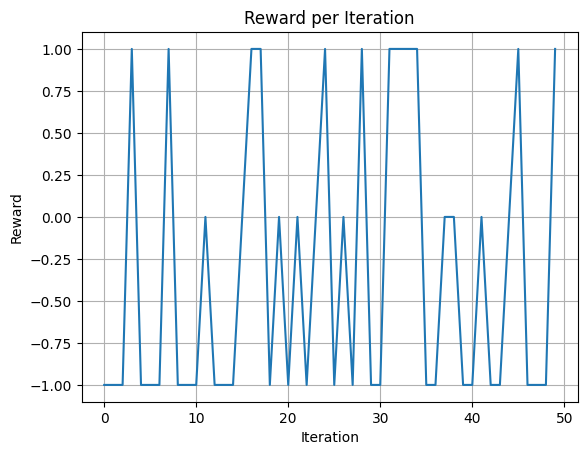

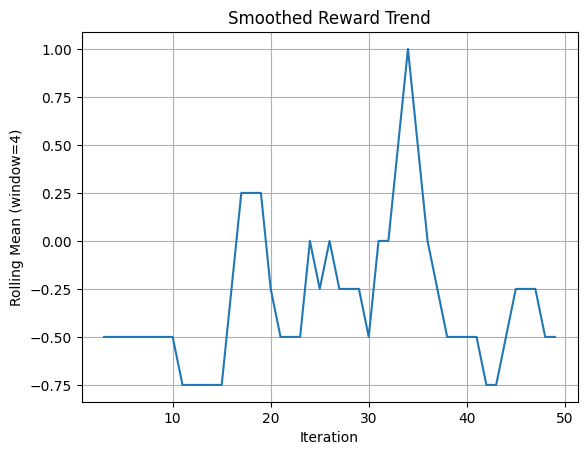

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load reward history from disk
df = pd.read_csv("all_rewards.csv", header=None, names=["reward"])

# Plot 1: Raw reward per iteration
plt.figure()
plt.plot(df["reward"].values)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward per Iteration")
plt.grid(True)
plt.show()

# Plot 2: Rolling mean for smoothing
window = 4
if len(df) >= window:
    rolling = df["reward"].rolling(window).mean()
    plt.figure()
    plt.plot(rolling)
    plt.xlabel("Iteration")
    plt.ylabel(f"Rolling Mean (window={window})")
    plt.title("Smoothed Reward Trend")
    plt.grid(True)
    plt.show()
else:
    print(f"Not enough data points for rolling mean (need at least {window}, got {len(df)})")


In [ ]:
!zip -r player-rl.zip player_ckpt

	zip warning: name not matched: /content/opp‑ckpy

zip error: Nothing to do! (try: zip -r opp-rl.zip . -i /content/opp‑ckpy)
  adding: player_ckpt/ (stored 0%)
  adding: player_ckpt/merges.txt (deflated 57%)
  adding: player_ckpt/tokenizer_config.json (deflated 89%)
  adding: player_ckpt/vocab.json (deflated 61%)
  adding: player_ckpt/config.json (deflated 57%)
  adding: player_ckpt/README.md (deflated 65%)
  adding: player_ckpt/pytorch_model.bin (deflated 14%)
  adding: player_ckpt/special_tokens_map.json (deflated 69%)
  adding: player_ckpt/added_tokens.json (deflated 68%)
  adding: player_ckpt/adapter_config.json (deflated 56%)
  adding: player_ckpt/chat_template.jinja (deflated 76%)
  adding: player_ckpt/tokenizer.json (deflated 81%)
  adding: player_ckpt/adapter_model.safetensors (deflated 7%)


In [ ]:
!zip -r opp-rl.zip opp_ckpt


  adding: opp_ckpt/ (stored 0%)
  adding: opp_ckpt/merges.txt (deflated 57%)
  adding: opp_ckpt/tokenizer_config.json (deflated 89%)
  adding: opp_ckpt/vocab.json (deflated 61%)
  adding: opp_ckpt/config.json (deflated 57%)
  adding: opp_ckpt/README.md (deflated 65%)
  adding: opp_ckpt/pytorch_model.bin (deflated 14%)
  adding: opp_ckpt/special_tokens_map.json (deflated 69%)
  adding: opp_ckpt/added_tokens.json (deflated 68%)
  adding: opp_ckpt/adapter_config.json (deflated 56%)
  adding: opp_ckpt/chat_template.jinja (deflated 76%)
  adding: opp_ckpt/tokenizer.json (deflated 81%)
  adding: opp_ckpt/adapter_model.safetensors (deflated 7%)
